In [ ]:
 !pip install gluonnlp
!pip install mxnet

     |████████████████████████████████| 348kB 8.5MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595678 sha256=8336f5fd03cf78b2a893d9817661aae3310a0292e901e8251b171f9a2ceb3365
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 46.9MB 85kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import gluonnlp as nlp
import gc
import time
import warnings
import pandas as pd 
import numpy as np
from matplotlib.pyplot import imread
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
import matplotlib_venn as venn
import scipy.stats as ss
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import keras.backend
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam
import string
import re 
import nltk
from nltk.corpus import stopwords
import spacy
import nltk
import collections
from tqdm import tqdm
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving test.csv to test.csv
Saving test_labels.csv to test_labels.csv
Saving train.csv to train.csv


In [ ]:
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
%matplotlib inline
nltk.download('stopwords') #-----must------
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")
print("ALL OKAY")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
ALL OKAY


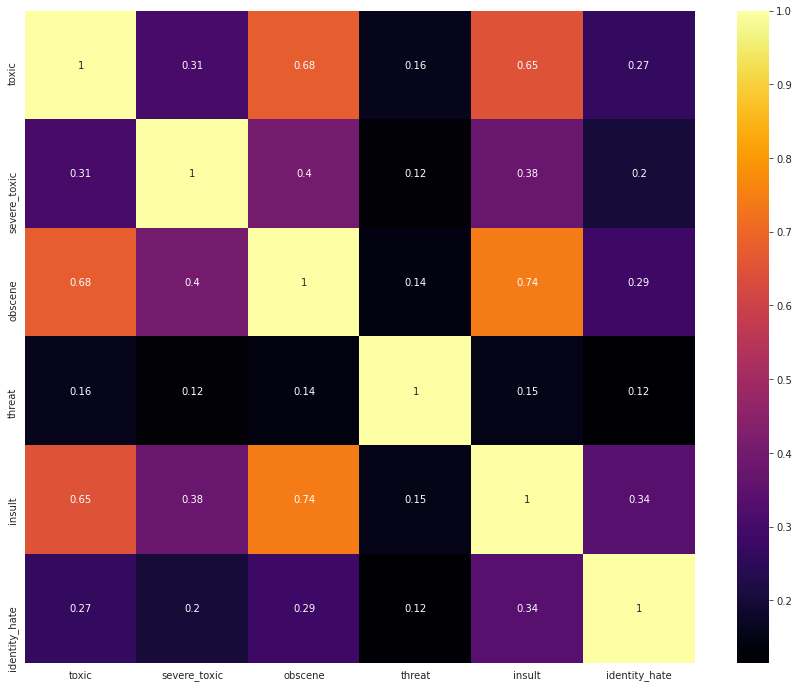

In [ ]:
plt.rcParams['figure.figsize'] = (15, 12)
sns.heatmap(train.corr(), cmap='inferno', annot=True)
plt.show()

In [ ]:
null_check=train.isnull().sum()
print(null_check)
null_check=test.isnull().sum()
print(null_check)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
id              0
comment_text    0
dtype: int64


In [ ]:
train["comment_text"].fillna("blank", inplace=True)
test["comment_text"].fillna("blank", inplace=True)
temp_df=train.iloc[:,0:-1]
train.head(500)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
495,014b44616d8cb457,"Sarek of Vulcan: Unfortunately for you, you ca...",0,0,0,0,0,0
496,014bb932bd289352,Keep your chin up! Darwinism was not accepted ...,0,0,0,0,0,0
497,014c96f873db11ff,"""""""Nazi filth"""" is impolite 04:27, 20 Jan 200...",1,0,0,0,1,0
498,014d00c8f2a76df4,Interesting. I checked the other case number K...,0,0,0,0,0,0


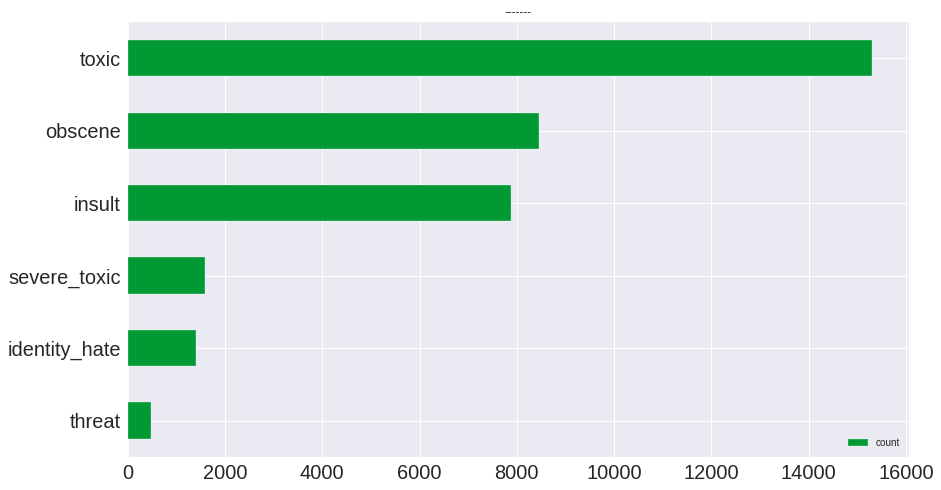

In [ ]:
columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
ff= train[columns].sum().to_frame().rename(columns={0:'count'}).sort_values('count')
import seaborn as sns
plt.style.use('seaborn')
ff.plot.barh(y='count', title="-------", figsize=(14,8),color='#009933', fontsize=20)

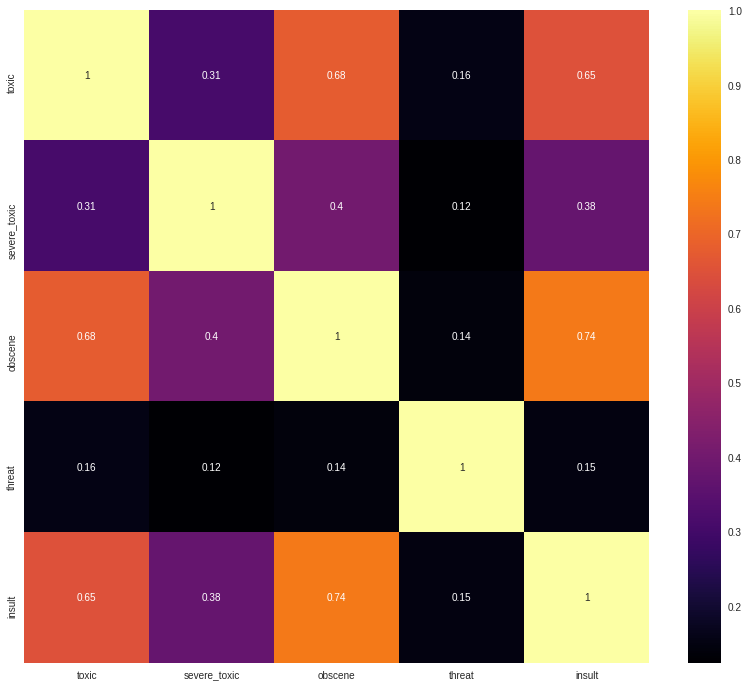

In [ ]:
temp_df=train.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="inferno")

In [ ]:
corr_mats=[]
main_col='toxic'
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

out

severe_toxic       obscene        threat       insult      
severe_toxic            0     1       0     1       0    1       0     1
toxic                                                                   
0                  144277     0  143754   523  144248   29  143744   533
1                   13699  1595    7368  7926   14845  449    7950  7344

In [ ]:
y_train = train[columns].values
x_train = train["comment_text"]
x_test  = test["comment_text"]
word_counter = collections.Counter([word for sentence in tqdm(x_train, total=len(x_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('20 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|██████████| 159571/159571 [00:01<00:00, 95505.15it/s]


10734904 words.
532299 unique words.
20 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


In [ ]:
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371



In [ ]:
# use trained embedding module
# download module and unzip file
import os
import urllib.request
import zipfile
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip', 'wiki.en.zip')

# unzip files
zip_model = zipfile.ZipFile('wiki.en.zip', 'r')
zip_model.extractall('./')
zip_model.close()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(x_train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))
embedding_dim = 300
embeddings_index = {}
f = open('wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


In [ ]:
import h5py
with h5py.File('yesss.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)
with h5py.File('yesss.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]

In [ ]:
#-----CNN---------
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layers
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))

# Add Convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Summarize the model
model.summary()

def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)
       
lr = .0001
model.compile(loss=loss, optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 371, 300)          63101400  
_________________________________________________________________
conv1d (Conv1D)              (None, 371, 128)          192128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 123, 128)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='model.best.hdf5',validation_data=(X_val, y_val), interval=1)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='binary_crossentropy', optimizer='Adam')
batch_size = 64
epochs = 2

early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=1, shuffle=False)


Epoch 1/2
2419/2419 [==============================] - 2503s 1s/step - loss: 0.1154 - val_loss: 0.0438
 - AUC - improved from 0.00000 to 0.98524
Epoch 2/2
2419/2419 [==============================] - 2496s 1s/step - loss: 0.0403 - val_loss: 0.0454
 - AUC - improved from 0.98524 to 0.98634


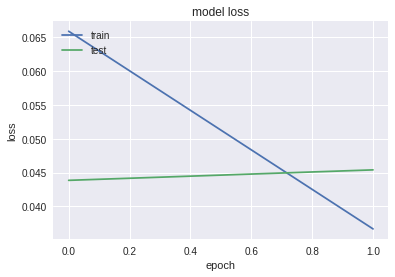

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         100%
Severe Toxic:  16%
Obscene:       92%
Threat:        1%
Insult:        92%
Identity Hate: 10%

Toxicity levels for 'i will kill you':
Toxic:         99%
Severe Toxic:  1%
Obscene:       4%
Threat:        97%
Insult:        11%
Identity Hate: 0%

Toxicity levels for 'have a nice day':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'u r ugly as my jackass':
Toxic:         100%
Severe Toxic:  14%
Obscene:       98%
Threat:        0%
Insult:        89%
Identity Hate: 0%

Toxicity levels for 'you son of a bitch':
Toxic:         100%
Severe Toxic:  25%
Obscene:       99%
Threat:        0%
Insult:        97%
Identity Hate: 1%

Toxicity levels for 'stupid boy!!':
Toxic:         97%
Severe Toxic:  1%
Obscene:       42%
Threat:        0%
Insult:        70%
Identity Hate: 2%

Toxicity levels for 'let me fuck you':
Toxic:         100%
Severe Toxic: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


predictions = model.predict(processed_X_test, verbose=0)

def toxicity_level(string):
   
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('u r ugly as my jackass')
toxicity_level('you son of a bitch')
toxicity_level('stupid boy!!')
toxicity_level('let me fuck you')
toxicity_level('you bastard!')
toxicity_level('I am a Human')